In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [2]:
# if using google colab, upload the zip file and then run this cell to unzip the file.
!unzip PianoFingeringDataset_v1.2.zip

unzip:  cannot find or open PianoFingeringDataset_v1.2.zip, PianoFingeringDataset_v1.2.zip.zip or PianoFingeringDataset_v1.2.zip.ZIP.


In [2]:
# RELEVANT CONSTANTS
PATH_TO_DATASET_FOLDER = './PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/FingeringFiles'
PATH_TO_METADATA = './PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/List.csv'
FINGERING_TYPE_TO_ANALYZE = "1"    # there are 8 distinct fingerings done by 8 different people


## NEED TO FIX: FINGERING_TYPE_TO_ANALYZE IS NOT CORRECT: NEED TO LOOK AT THE STRING NOT THE NUMEBR!!!!! 1 can be YI and ES for diff pieces!!!


# Setup
## Overview of the metadata

As can be seen from the metadata, we have a bunch of classical pieces by (old) composers. Basically how PIG works is that there are **8 fingerings** done by 8 different individuals: you want to make sure to **use fingerings from the SAME finger-er** in your training data for consistency!

In [4]:
# This cell loads in 'lists.csv', which is a simple CSV file that links IDs to actual pieces, with some extra metadata about the pieces themselves
song_metadata_dir_path = PATH_TO_METADATA

print(song_metadata_dir_path)
if os.path.isfile(song_metadata_dir_path):
    song_metadata_df = pd.read_csv(song_metadata_dir_path, skiprows=1, names=["id", "composer", "piece", "num_bars", "num_notes", "num_types_of_fingerings_provided", "fingering_1", "fingering_2", "fingering_3", "fingering_4", "fingering_5", "fingering_6", "fingering_7", "fingering_8"])
    print(song_metadata_df.head(10))
else:
    print("invalid filepath!")

./PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/List.csv
   id composer                                              piece  num_bars  \
0   1     Bach                      Two-part invention in C major        22   
1   2     Bach                      Two-part invention in F major        34   
2   3     Bach  Well-Tempered Clavier, Book I, Prelude No. 23 ...        19   
3   4     Bach  Well-Tempered Clavier, Book II, Fugue No. 2 in...        14   
4   5     Bach  Well-Tempered Clavier, Book II, Fugue No. 19 i...        14   
5   6     Bach                             Partita No. 6 Corrente        38   
6   7     Bach                       French Suite No. 1 Allemande        12   
7   8     Bach                       French Suite No. 5 Sarabande        16   
8   9     Bach                        English Suite No. 3 Prelude        33   
9  10     Bach                  Goldberg Variations, Variation 13        16   

   num_notes  num_types_of_fingerings_provided fingering_1 finger

## Tokenize

AI models process floating point numbers. So we need to make sure all the fields are numbers, and so we establish this dictionary mapping:

In [139]:
directory_path = PATH_TO_DATASET_FOLDER

# every pitch is a combination of a note and octave
pitch_classes = ['Ab', 'A', 'A#', 'Bb', 'B', 'B#', 'Cb', 'C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'E#', 'Fb', 'F', 'F#', 'Gb', 'G', 'G#']
octaves = range(0, 9)
pitch_to_int_mapping = {f"{pc}{octave}": i for i, (pc, octave) in enumerate((pc, o) for o in octaves for pc in pitch_classes)}
int_to_pitch_mapping = {i: f"{pc}{octave}" for i, (pc, octave) in enumerate((pc, o) for o in octaves for pc in pitch_classes)}

fingerings = [
    '1', '2', '3', '4', '5',
    '1_', '2_', '3_', '4_', '5_', 
    '-1', '-2', '-3', '-4', '-5', 
    '1_2', '1_3', '1_4', '1_5', 
    '1_-2', '1_-3', '1_-4', '1_-5', 
    '2_1', '2_3', '2_4', '2_5', 
    '2_-1', '2_-3', '2_-4', '2_-5', 
    '3_1', '3_2', '3_4', '3_5', 
    '3_-1', '3_-2', '3_-4', '3_-5', 
    '4_1', '4_2', '4_3', '4_5', 
    '4_-1', '4_-2', '4_-3', '4_-5', 
    '5_1', '5_2', '5_3', '5_4',
    '5_-1', '5_-2', '5_-3', '5_-4',
    '-1_-2', '-1_-3', '-1_-4', '-1_-5',
    '-1_2', '-1_3', '-1_4', '-1_5', 
    '-2_-3', '-2_-4', '-2_-5', '-2_-1',
    '-2_3', '-2_4', '-2_5', '-2_1',
    '-3_-4', '-3_-5', '-3_-2', '-3_-1',
    '-3_4', '-3_5', '-3_2', '-3_1',
    '-4_-5', '-4_-3', '-4_-2', '-4_-1',
    '-4_5', '-4_3', '-4_2', '-4_1',
    '-5_-1', '-5_-2', '-5_-3', '-5_-4',
    '-5_1', '-5_2', '-5_3', '-5_4',
    '1_2_3', '1_2_4', '1_2_5', '1_3_4', '1_3_5', '1_4_5', '2_3_4', '2_3_5', '2_4_5', '3_4_5',
    '-1_1', '-2_2', '-3_3', '-4_4', '-5_5', '1_-1', '2_-2', '3_-3', '4_-4', '5_-5', '0'
]
finger_to_int_mapping = {f: i for i, f in enumerate(fingerings)}
int_to_finger_mapping = {i: f for i, f in enumerate(fingerings)}


# verify that every finger and pitch in our data can be mapped correctly
verify_spelled_pitch_values = set()
verify_fingering_map = set()
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        verify_spelled_pitch_values.update(df['spelled_pitch'].unique())
        verify_fingering_map.update(df['finger_number'].unique())
verify_fingering_map = {str(x) for x in verify_fingering_map}

if not verify_fingering_map.issubset(set(finger_to_int_mapping.keys())):
    print("INVALID FINGER SYMBOL DETECTED: ", verify_fingering_map - set(finger_to_int_mapping.keys()))
elif not verify_spelled_pitch_values.issubset(set(pitch_to_int_mapping.keys())):
    print("INVALID PITCH SYMBOL DETECTED: ", verify_spelled_pitch_values - set(pitch_to_int_mapping.keys()))
else:
    print("pitch_to_int_mapping: ", pitch_to_int_mapping)
    print("\n")
    print("finger_to_int_mapping: ", finger_to_int_mapping)


pitch_to_int_mapping:  {'Ab0': 0, 'A0': 1, 'A#0': 2, 'Bb0': 3, 'B0': 4, 'B#0': 5, 'Cb0': 6, 'C0': 7, 'C#0': 8, 'Db0': 9, 'D0': 10, 'D#0': 11, 'Eb0': 12, 'E0': 13, 'E#0': 14, 'Fb0': 15, 'F0': 16, 'F#0': 17, 'Gb0': 18, 'G0': 19, 'G#0': 20, 'Ab1': 21, 'A1': 22, 'A#1': 23, 'Bb1': 24, 'B1': 25, 'B#1': 26, 'Cb1': 27, 'C1': 28, 'C#1': 29, 'Db1': 30, 'D1': 31, 'D#1': 32, 'Eb1': 33, 'E1': 34, 'E#1': 35, 'Fb1': 36, 'F1': 37, 'F#1': 38, 'Gb1': 39, 'G1': 40, 'G#1': 41, 'Ab2': 42, 'A2': 43, 'A#2': 44, 'Bb2': 45, 'B2': 46, 'B#2': 47, 'Cb2': 48, 'C2': 49, 'C#2': 50, 'Db2': 51, 'D2': 52, 'D#2': 53, 'Eb2': 54, 'E2': 55, 'E#2': 56, 'Fb2': 57, 'F2': 58, 'F#2': 59, 'Gb2': 60, 'G2': 61, 'G#2': 62, 'Ab3': 63, 'A3': 64, 'A#3': 65, 'Bb3': 66, 'B3': 67, 'B#3': 68, 'Cb3': 69, 'C3': 70, 'C#3': 71, 'Db3': 72, 'D3': 73, 'D#3': 74, 'Eb3': 75, 'E3': 76, 'E#3': 77, 'Fb3': 78, 'F3': 79, 'F#3': 80, 'Gb3': 81, 'G3': 82, 'G#3': 83, 'Ab4': 84, 'A4': 85, 'A#4': 86, 'Bb4': 87, 'B4': 88, 'B#4': 89, 'Cb4': 90, 'C4': 91, 'C#4'

In [140]:
# EXAMPLE CODE: Loading in the "x" features and "y" label for a specific piece, using piece number 14 as an example

specific_piece_id = 14

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    if piece_id == specific_piece_id:
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])

num_data, num_features = df.shape
x = df.iloc[:, 0:num_features - 1]
y = df.iloc[:, num_features - 1]


# convert "spelled pitch" field to a number
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)

#  do same for "finger_number" label
y = y.map(finger_to_int_mapping)

x = torch.tensor(x.values.tolist(), dtype=torch.float32)
y = torch.tensor(y.values.astype(float).tolist())
y = y.unsqueeze(1)   # conver from size [289] to size [289, 1]

print(f"x's shape is {x.shape}")
print(f"y's shape is {y.shape}")
print(f"num features is {num_features} and num data is {num_data}")
# print(x)
# print(y)

x's shape is torch.Size([289, 7])
y's shape is torch.Size([289, 1])
num features is 8 and num data is 289


In [141]:
# Helper function for plotting finger differences
def plot_sequence_finger_predictions(x_axis, y_true, y_pred, model_name=''):
    plt.figure(figsize=(50, 5))
    sns.lineplot(x=x_axis, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=x_axis, y=y_pred, marker='x', markersize=8, label='Predicted')

    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)  # Slight rotation for readability
    plt.grid(True, linestyle='--', alpha=0.6)  # Light grid for reference
    plt.legend(fontsize=12)
    plt.show()

# Logistic Regression

In preparation we basically split the data into train/test/validation. Then we separate out the features into a giant X dataframe, and the labels into a giant Y dataframe. To do the baseline we just use logistic regression to just fit X and y.

**This is mostly just done for testing purposes and to get more familiar with using PyTorch - obviously you can't just look at the features to suss out the correct fingering: you need sequential reasoning!**

Logistic Regression Test Accuracy: 36.45%. Makes sense - the model is likely just predicting the most common "average" fingers to minimize loss.


**NOTE 1:** There are 8 distinct fingering types, need to isolate by fingering type for accurate predictions
**NOTE 2:** this is a __multi-class__ logistic regression model since there are multiple outputs for fingers

In [144]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

FINGERING_TYPE_TO_ANALYZE = "1" 

#################################
# 1) LOAD ALL DATA INTO ONE DF
#################################
directory_path = PATH_TO_DATASET_FOLDER

all_rows = []
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')                # 114-7
    piece_id, fingering_type = fingering_label.split('-')   # e.g. piece 114, finger_kind 7 (out of 8)
    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == fingering_type:
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        df["source_file"] = filename
        all_rows.append(df)

# at this point, all_rows contians EVERY SINGLE PIECE that is of a certain kind of fingering type.
# print(all_rows)
all_data = pd.concat(all_rows, ignore_index=True)     # concat all X rows of that kind of fingering into a GIANT X dataframe to fit
# print("Loaded shape:", all_data.shape)
print(all_data.head())

##################################################
# 2) ENCODE CATEGORICAL COLUMNS INTO INTEGERS
##################################################
all_data["spelled_pitch_int"] = all_data["spelled_pitch"].map(pitch_to_int_mapping)    
all_data["finger_int"] = all_data["finger_number"].astype(str).map(finger_to_int_mapping)    # need to first cast everything to str, then apply the dict mapping we had originally

##################################################
# 3) WRANGLE INTO X AND Y DATAFRAMES
##################################################
feature_cols = [
    "spelled_pitch_int",
    "onset_time",
    "offset_time",
    "onset_velocity",
    "offset_velocity",
    "channel"
]
label_col = "finger_int"

X = all_data[feature_cols].values
y = all_data[label_col].values
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)


##################################################
# 4A) LINEAR CLASSIFIER BASELINE (Logistic Regression)
##################################################

print("\n============================")
print("LOGISTIC REGRESSION BASELINE")
print("============================")

clf = LogisticRegression(
    multi_class='multinomial', max_iter=1000, random_state=42
)
clf.fit(X, y)

y_pred_test_clf = clf.predict(X_test)
test_acc_clf = accuracy_score(y_test, y_pred_test_clf)

print(f"Logistic Regression test accuracy = {test_acc_clf:.4f}")

   noteID  onset_time  offset_time spelled_pitch  onset_velocity  \
0       0    0.005053     0.127843            F7             109   
1       1    0.005053     0.230926            A1             112   
2       2    0.118242     0.213240            C7              88   
3       3    0.203639     0.298637            E7              88   
4       4    0.289037     0.383024            A6              88   

   offset_velocity  channel finger_number          source_file  
0               80        0             5  078-1_fingering.txt  
1               80        1            -5  078-1_fingering.txt  
2               80        0             2  078-1_fingering.txt  
3               80        0             3  078-1_fingering.txt  
4               80        0             1  078-1_fingering.txt  

LOGISTIC REGRESSION BASELINE


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression test accuracy = 0.3645


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Inference Demo with Logistic Regression
Given a piece, we can visualize the differences in fingerings with a simple plot. As can be seen, for this piece at least, we're able to predict the high fingers pretty well but it keeps "averaging" low fingers and the predictions aren't very interesting.

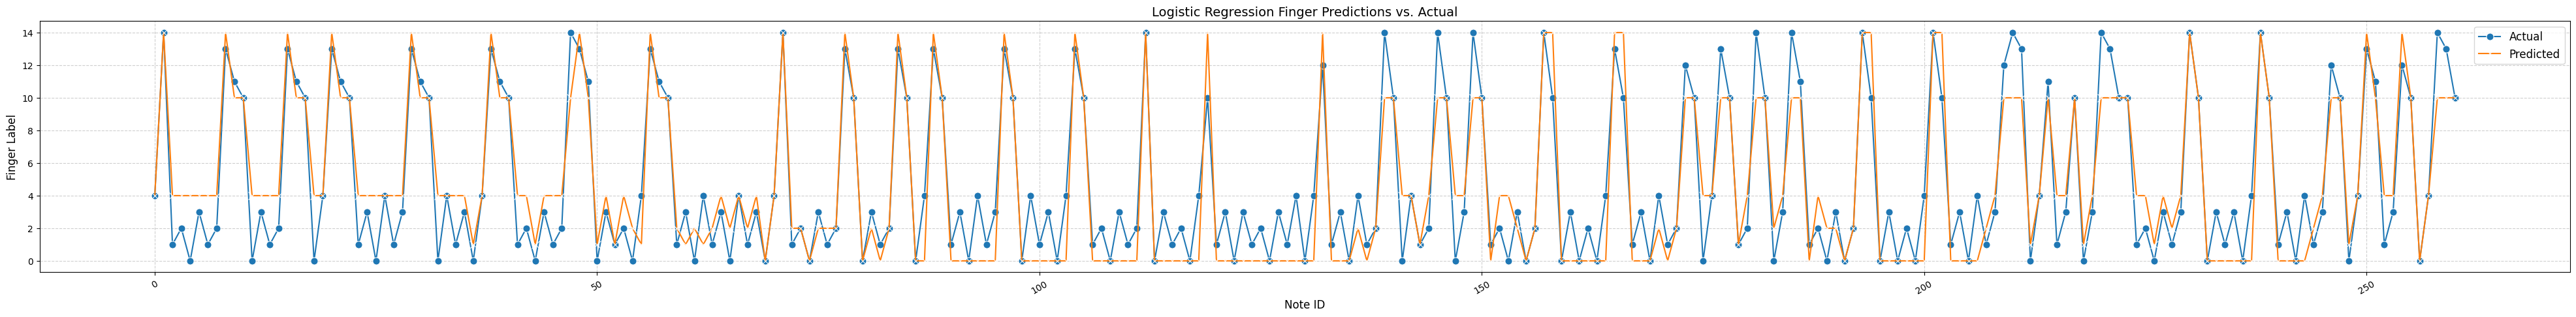

Final Accuracy: 0.3180


In [146]:
import pandas as pd
import numpy as np
import os

# Suppose you want to load and predict fingerings for this piece:
piece_file = "078-1_fingering.txt"    # SPECIFIC .TXT FILE IN THE PIG FORMAT YOU WANT TO PREDICT WITH
file_path = os.path.join(directory_path, piece_file)
df_piece = pd.read_table(
    file_path,
    sep="\t",
    skiprows=1,
    names=[
        "noteID",
        "onset_time",
        "offset_time",
        "spelled_pitch",
        "onset_velocity",
        "offset_velocity",
        "channel",
        "finger_number"
    ],
)

df_piece["spelled_pitch_int"] = df_piece["spelled_pitch"].map(pitch_to_int_mapping)
df_piece["finger_int"] = df_piece["finger_number"].astype(str).map(finger_to_int_mapping)

y_actual = df_piece["finger_int"].tolist()

X_input = df_piece[feature_cols].values 

y_pred = clf.predict(X_input)

# can decode back to correct finger labels like so:
# int_to_finger = {v: k for k, v in finger_to_int.items()}
# y_pred_labels = [int_to_finger[idx] for idx in y_pred]

x = range(0, len(y_pred))

# print(f"Predicted fingerings for '{piece_file}':")
# print(y_pred)
# print("\nActual fingerings:")
# print(y_actual)

plot_sequence_finger_predictions(x, y_actual, y_pred, 'Logistic Regression')

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_actual, y_pred)
print(f"Final Accuracy: {accuracy:.4f}")



# Setup for Sequence Model Experiments on PIG Data

# NOTE THAT ALL THE INFERNENCE CODE ONLY WORKS FOR DATASET 1 FOR NOW SINCE IT PROCESSES THE ENTIRE PIECE

We first create the relevant dataloaders and isolate the sequences for easy data access. Also include training loop code.

## Variable Length Dataset
RNNs can process datasets of **variable length**, so there's no specific "sequence length" to speak of here.


### VARIANT 0: Input sequence is entire piece
Here the Xs and ys refer to ENTIRE PIECES: the X tensor contains a list of vectors of a bunch of notes, and the y tensor contains one finger annotation corresponding to each of those vectors.

In [97]:
directory_path = PATH_TO_DATASET_FOLDER

all_sequences = []   # will hold raw DataFrames for each piece
all_piece_names = []

FINGERING_TYPE_TO_ANALYZE = 1

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')  # e.g. "001-01"
    piece_id, fingering_type = fingering_label.split('-')

    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == int(fingering_type):
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        all_piece_names.append(filename)
        all_sequences.append(df)

print(f"Total number of pieces found: {len(all_sequences)}")
raw_encoded_sequences_variant_0 = []  # STORES TUPLES OF (X_SEQ, Y_LIST_OF_FINGERINGS_FOR_EVERY_X_IN_THE_SEQ)

for df in all_sequences:
    X_list = []
    y_list = []
    for row in df.itertuples(index=False):
        spelled_pitch = row.spelled_pitch
        finger_str = str(row.finger_number)

        # encode pitch and finger
        pitch_int = pitch_to_int_mapping.get(spelled_pitch, 0)  # fallback 0 if unseen
        finger_int = finger_to_int_mapping.get(finger_str, 0)   # fallback 0 if unseen
        feature_row = [
            pitch_int,
            float(row.onset_time),
            float(row.offset_time),
            float(row.onset_velocity),
            float(row.offset_velocity),
            float(row.channel)
        ]
        X_list.append(feature_row)
        y_list.append(finger_int)

    raw_encoded_sequences_variant_0.append((X_list, y_list))

Total number of pieces found: 148


### Variant 1: Set sequence length of 30 notes
Take groups of 30 notes based on the note IDs.

In [106]:
import os
import pandas as pd

SEQUENCE_LENGTH = 30
HALF_WINDOW = SEQUENCE_LENGTH // 2  # For centering the window (15 before, 15 after)

# Define pad tokens: a pad feature row (6 features) and pad finger value.
PAD_X = [0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Adjust if you wish a different pad
PAD_Y = 0  # Use a value that is not in your finger mapping

directory_path = PATH_TO_DATASET_FOLDER
all_sequences = []   # will hold raw DataFrames for each piece
all_piece_names = []
FINGERING_TYPE_TO_ANALYZE = 1

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')  # e.g. "001-01"
    piece_id, fingering_type = fingering_label.split('-')

    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == int(fingering_type):
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        all_piece_names.append(filename)
        all_sequences.append(df)

print(f"Total number of pieces found: {len(all_sequences)}")

# Create fixed-length sequences (centered windows) for every note in each piece.
raw_encoded_sequences_variant1 = []  # Each element is a tuple (X_seq, y_seq) of length 30

for df in all_sequences:
    X_list = []
    y_list = []
    # Build feature lists for the piece (noteID is used only for ordering; not added to features)
    for row in df.itertuples(index=False):
        spelled_pitch = row.spelled_pitch
        finger_str = str(row.finger_number)

        # Encode pitch and finger (using your mappings)
        pitch_int = pitch_to_int_mapping.get(spelled_pitch, 0)  # fallback 0 if unseen
        finger_int = finger_to_int_mapping.get(finger_str, 0)    # fallback 0 if unseen

        feature_row = [
            pitch_int,
            float(row.onset_time),
            float(row.offset_time),
            float(row.onset_velocity),
            float(row.offset_velocity),
            float(row.channel)
        ]
        X_list.append(feature_row)
        y_list.append(finger_int)
    
    n = len(X_list)
    # For every note, create a window of SEQUENCE_LENGTH with the note in the center.
    for i in range(n):
        # Determine window boundaries (they might be out-of-bounds)
        start_idx = i - HALF_WINDOW
        end_idx = i + HALF_WINDOW  # This gives SEQUENCE_LENGTH elements overall
        X_seq = []
        y_seq = []
        for j in range(start_idx, end_idx):
            if j < 0 or j >= n:
                X_seq.append(PAD_X)
                y_seq.append(PAD_Y)
            else:
                X_seq.append(X_list[j])
                y_seq.append(y_list[j])
        raw_encoded_sequences_variant1.append((X_seq, y_seq))

print("Variant 1: For a sample piece, X sequence length =", len(raw_encoded_sequences_variant1[0][0]))




Total number of pieces found: 148
Variant 1: For a sample piece, X sequence length = 30


### Variant 2: Based on a 5 second interval, still a 30 note sequence with padding

In [111]:
import os
import pandas as pd

TIME_WINDOW = 5.0  # seconds
MAX_NOTES = 30     # Maximum notes per sequence

# Define pad tokens: same as before.
PAD_X = [0, 0.0, 0.0, 0.0, 0.0, 0.0]
PAD_Y = 0

directory_path = PATH_TO_DATASET_FOLDER
all_sequences = []   # will hold raw DataFrames for each piece
all_piece_names = []
FINGERING_TYPE_TO_ANALYZE = 1

# Read in all pieces.
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')  # e.g. "001-01"
    piece_id, fingering_type = fingering_label.split('-')

    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == int(fingering_type):
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        all_piece_names.append(filename)
        all_sequences.append(df)

print(f"Total number of pieces found: {len(all_sequences)}")

raw_encoded_sequences_variant2 = []  # Each element is a tuple (X_seq, y_seq) of length MAX_NOTES

for df in all_sequences:
    X_list = []
    y_list = []
    onset_times = []
    # Build feature lists for the piece.
    for row in df.itertuples(index=False):
        spelled_pitch = row.spelled_pitch
        finger_str = str(row.finger_number)

        pitch_int = pitch_to_int_mapping.get(spelled_pitch, 0)
        finger_int = finger_to_int_mapping.get(finger_str, 0)
        feature_row = [
            pitch_int,
            float(row.onset_time),
            float(row.offset_time),
            float(row.onset_velocity),
            float(row.offset_velocity),
            float(row.channel)
        ]
        X_list.append(feature_row)
        y_list.append(finger_int)
        onset_times.append(float(row.onset_time))
    
    if len(X_list) == 0:
        continue

    # Create time windows starting at the first note and moving forward by TIME_WINDOW.
    t_start = onset_times[0]
    t_end = onset_times[-1]
    current_window_start = t_start

    while current_window_start <= t_end:
        # Collect indices of notes whose onset time falls within [current_window_start, current_window_start + TIME_WINDOW)
        indices = [i for i, t in enumerate(onset_times) if current_window_start <= t < current_window_start + TIME_WINDOW]
        if len(indices) == 0:
            # No notes in this window; move to the next window.
            current_window_start += TIME_WINDOW
            continue
        
        # If more than MAX_NOTES, keep only the first MAX_NOTES.
        indices = indices[:MAX_NOTES]
        X_seq = [X_list[i] for i in indices]
        y_seq = [y_list[i] for i in indices]
        
        # Pad the sequence to ensure it has exactly MAX_NOTES tokens.
        pad_len = MAX_NOTES - len(X_seq)
        # Here we pad on the right; if you prefer symmetric padding, adjust accordingly.
        X_seq = X_seq + [PAD_X] * pad_len
        y_seq = y_seq + [PAD_Y] * pad_len
        
        raw_encoded_sequences_variant2.append((X_seq, y_seq))
        
        # Advance the window by TIME_WINDOW seconds (non-overlapping segments).
        current_window_start += TIME_WINDOW

print("Variant 2: For a sample window, X sequence length =", len(raw_encoded_sequences_variant2[0][0]))


Total number of pieces found: 148
Variant 2: For a sample window, X sequence length = 30


In [136]:
SPECIFIC_VARIANT_TO_USE = raw_encoded_sequences_variant_0
raw_encoded_sequences = SPECIFIC_VARIANT_TO_USE

In [113]:
print("x sequence length: ", len(raw_encoded_sequences[0][0]))
print("y sequence length (should match): ", len(raw_encoded_sequences[0][-1]))

# potentially do scaling/some kind of layernorm???
train_val_seqs, test_seqs = train_test_split(raw_encoded_sequences, test_size=0.2, random_state=42)
train_seqs, val_seqs = train_test_split(train_val_seqs, test_size=0.25, random_state=42)

print(f"Total pieces: {len(raw_encoded_sequences)}")
print(f"Train pieces: {len(train_seqs)}")
print(f"Val pieces:   {len(val_seqs)}")
print(f"Test pieces:  {len(test_seqs)}")

x sequence length:  30
y sequence length (should match):  30
Total pieces: 45976
Train pieces: 27585
Val pieces:   9195
Test pieces:  9196


In [114]:
# DATASET LOADER CLASS

class FingeringDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X_list, y_list = self.sequences[idx]
        X_tensor = torch.tensor(X_list, dtype=torch.float32)  # (seq_len, 6)
        y_tensor = torch.tensor(y_list, dtype=torch.long)     # (seq_len,)
        return X_tensor, y_tensor

train_dataset = FingeringDataset(train_seqs)
val_dataset   = FingeringDataset(val_seqs)
test_dataset  = FingeringDataset(test_seqs)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)


In [115]:
# training loop
def train_sequence_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for X_seq, y_seq in train_loader:
            # print("X_seq: ", X_seq)
            # print("y_seq: ", y_seq)

            X_seq = X_seq.to(device, non_blocking=True)
            y_seq = y_seq.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(X_seq)    # forward pass

            # reshape for CrossEntropy by flattening tokens => (batch_size * seq_len, num_fingers)
            logits_reshaped = logits.view(-1, logits.size(-1))
            y_seq_reshaped = y_seq.view(-1)

            loss = criterion(logits_reshaped, y_seq_reshaped)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate_sequence_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | ValAcc: {val_acc:.4f}")

# doing inference for validation
def evaluate_sequence_model(model, data_loader):
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_seq, y_seq in data_loader:
            # X_seq: (batch_size, seq_len, num_features)
            # y_seq: (batch_size, seq_len)

            X_seq = X_seq.to(device, non_blocking=True)
            y_seq = y_seq.to(device, non_blocking=True)

            logits = model(X_seq)  # => (batch_size, seq_len, num_fingers)
            preds = torch.argmax(logits, dim=-1)  # => (batch_size, seq_len)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(y_seq.view(-1).cpu().numpy())

    return accuracy_score(all_labels, all_preds)


# RNN

RNNs are specialized for sequence modeling: they keep track of an internal hidden state and then "unroll" that state vector to get the corresponding output sequence.

Performance running on 250 epochs leads to a test accuracy of **47.8%** - certainly better than logistic regression alone, suggesting that the sequential nature of the RNN does lead it to learn better. However, it's still not great. 

In [116]:
# RNN MODEL
class PianoRNNModel(nn.Module):
    def __init__(
        self,
        num_pitches,     # size of pitch vocab
        num_fingers,     # number of finger classes
        embed_dim=32,    # dimension for pitch embedding
        hidden_dim=64,   # dimension for RNN hidden layer
        numeric_dim=5,   # number of extra numeric features
    ):
        super().__init__()

        # have 2 embedding vectors: one for pitch and the other numeric features. We then concatenate them and that ends up being the hidden state of our RNN.
        self.embedding_pitch = nn.Embedding(num_pitches, embed_dim)        # Embedding for pitch (categorical)
        self.embedding_numeric = nn.Linear(numeric_dim, embed_dim)     # A simple linear projection for numeric features => same embed_dim so we can concatenate them with pitch embeddings

        self.rnn = nn.RNN(embed_dim * 2, hidden_dim, batch_first=True)         # RNN: input_dim = embed_dim(pitch) + embed_dim(numeric) = 2*embed_dim
        self.fc = nn.Linear(hidden_dim, num_fingers)   # Final linear layer to map hidden_dim => number of finger classes

    def forward(self, x):
        pitch_ids = x[..., 0].long()         # shape => (batch_size, seq_len)
        numeric_feats = x[..., 1:].float()   # shape => (batch_size, seq_len, 5)

        # Embed pitch and numeric separately
        pitch_emb = self.embedding_pitch(pitch_ids)  # (batch_size, seq_len, embed_dim)
        numeric_emb = self.embedding_numeric(numeric_feats)  # (batch_size, seq_len, embed_dim)

        # Concatenate along last dimension => (batch_size, seq_len, 2*embed_dim)
        combined_emb = torch.cat((pitch_emb, numeric_emb), dim=2)

        # RNN => (batch_size, seq_len, hidden_dim)
        rnn_out, _ = self.rnn(combined_emb)

        # Final linear => (batch_size, seq_len, num_fingers)
        logits = self.fc(rnn_out)
        return logits

In [120]:
# COMMENT OUT THESE LINES WHEN YOU WANT TO CONTINUE TRAINING WITHOUT OVERWRITING YOUR PREVIOUS GAINS!
# rnn_model = PianoRNNModel(
#     num_pitches=len(pitch_to_int_mapping),
#     num_fingers=len(finger_to_int_mapping),
#     embed_dim=32,
#     hidden_dim=64,
#     numeric_dim=5
# )

state_dict = torch.load('rnn_model_weights.pth')
rnn_model.load_state_dict(state_dict)

train_sequence_model(rnn_model, train_loader, val_loader, num_epochs=4, lr=1e-3)
test_acc_rnn = evaluate_sequence_model(rnn_model, test_loader)
print(f"RNN Test Accuracy = {test_acc_rnn:.4f}")
torch.save(rnn_model.state_dict(), "rnn_model_weights.pth")    # we save the RNN model weights at the very end so we can load them in later!

/tmp/ipykernel_7836/2006443040.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('rnn_model_weights.pth')


Epoch 1/4 | Loss: 0.9713 | ValAcc: 0.6130
Epoch 2/4 | Loss: 0.9579 | ValAcc: 0.6266
Epoch 3/4 | Loss: 0.9478 | ValAcc: 0.6219
Epoch 4/4 | Loss: 0.9497 | ValAcc: 0.6148
RNN Test Accuracy = 0.6156


In [134]:
total_params = sum(p.numel() for p in transformer_model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 46744


# LSTM
Code for the LSTM predictor is nearly identical: we just use a different model architecture.

We see this model is getting an accuracy of around **0.508**, slightly higher than the RNN (though not by much). The long-term capability of the LSTM does seem to help a little bit, although as expected the gain is not that much as piano fingerings tend to be localized.

In [121]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        num_pitches,     # size of pitch vocab
        num_fingers,     # number of finger classes
        embed_dim=32,    # dimension for pitch embedding
        hidden_dim=64,   # dimension for LSTM hidden layer
        numeric_dim=5,   # number of extra numeric features
    ):
        super().__init__()
        self.embedding_pitch = nn.Embedding(num_pitches, embed_dim)    # Embedding for pitch (categorical)
        self.embedding_numeric = nn.Linear(numeric_dim, embed_dim)     # Linear projection for numeric features
        self.lstm = nn.LSTM(embed_dim * 2, hidden_dim, batch_first=True)    # LSTM: input_dim = embed_dim(pitch) + embed_dim(numeric) = 2*embed_dim
        self.fc = nn.Linear(hidden_dim, num_fingers)     # Final linear layer to the num_fingers

    def forward(self, x):
        pitch_ids = x[..., 0].long()
        numeric_feats = x[..., 1:].float()

        # Embed pitch and fingering fields
        pitch_emb = self.embedding_pitch(pitch_ids)    # (batch_size, seq_len, embed_dim)
        numeric_emb = self.embedding_numeric(numeric_feats)  # (batch_size, seq_len, embed_dim)

        # Concatenate => (batch_size, seq_len, 2*embed_dim)
        combined_emb = torch.cat((pitch_emb, numeric_emb), dim=2)

        # LSTM => (batch_size, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(combined_emb)

        # Final linear => (batch_size, seq_len, num_fingers)
        logits = self.fc(lstm_out)
        return logits


In [125]:
# lstm_model = LSTMModel(
#     num_pitches=len(pitch_to_int_mapping),
#     num_fingers=len(finger_to_int_mapping),
#     embed_dim=32,
#     hidden_dim=64,
#     numeric_dim=5
# )

state_dict = torch.load('lstm_model_weights.pth')
lstm_model.load_state_dict(state_dict)

train_sequence_model(lstm_model, train_loader, val_loader, num_epochs=5, lr=1e-3)
test_acc_lstm = evaluate_sequence_model(lstm_model, test_loader)
print(f"LSTM Test Accuracy = {test_acc_lstm:.4f}")
torch.save(lstm_model.state_dict(), "lstm_model_weights.pth")    # we save the RNN model weights at the very end so we can load them in later!

/tmp/ipykernel_7836/1995516994.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('lstm_model_weights.pth')


Epoch 1/5 | Loss: 0.7505 | ValAcc: 0.7130
Epoch 2/5 | Loss: 0.7121 | ValAcc: 0.7146
Epoch 3/5 | Loss: 0.6829 | ValAcc: 0.7326
Epoch 4/5 | Loss: 0.6581 | ValAcc: 0.7465
Epoch 5/5 | Loss: 0.6383 | ValAcc: 0.7571
LSTM Test Accuracy = 0.7554


## DEMO: RNN/LSTM Piece Finger Annotation Prediction
Demo for how you can input any music piece in the PIG format into the model for predictions.

### Prediction Helper Function
Basically input a model, finger/pitch mappings, and a music PIG .txt file and it'll spit out the predictions that you can use to compare.

In [23]:
def predict_piece_fingerings_multi(
    model,
    file_path,
    pitch_to_idx,         # dict mapping spelled pitches -> int
    finger_to_idx=None,   # dict mapping finger labels -> int (optional)
    idx_to_finger=None,   # reverse mapping to decode predictions (optional)
    device=None
):
    df = pd.read_table(file_path, sep="\t", skiprows=1,
        names=[
            "noteID",
            "onset_time",
            "offset_time",
            "spelled_pitch",
            "onset_velocity",
            "offset_velocity",
            "channel",
            "finger_number",
        ],
    )

    # Encode spelled pitch -> int and finger labels -> int
    df["spelled_pitch_int"] = df["spelled_pitch"].map(pitch_to_int_mapping).fillna(0).astype(int)

    if finger_to_idx is not None:
        df["finger_int"] = df["finger_number"].astype(str).map(finger_to_int_mapping).fillna(0).astype(int)
        y_true = df["finger_int"].values
    else:
        y_true = None

    #    Construct multi-feature array X of shape (seq_len, 6)
    #    X[..., 0] = spelled_pitch_int (categorical)
    #    X[..., 1] = onset_time
    #    X[..., 2] = offset_time
    #    X[..., 3] = onset_velocity
    #    X[..., 4] = offset_velocity
    #    X[..., 5] = channel
    seq_len = len(df)
    X_array = np.zeros((seq_len, 6), dtype=np.float32)

    X_array[:, 0] = df["spelled_pitch_int"].astype(float)
    X_array[:, 1] = df["onset_time"].astype(float)
    X_array[:, 2] = df["offset_time"].astype(float)
    X_array[:, 3] = df["onset_velocity"].astype(float)
    X_array[:, 4] = df["offset_velocity"].astype(float)
    X_array[:, 5] = df["channel"].astype(float)

    X_tensor = torch.tensor(X_array, dtype=torch.float32).unsqueeze(0)    # convert X_array into a pytorch tensor

    # move everything to gpu if possible
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_tensor = X_tensor.to(device)
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(X_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    if idx_to_finger:
        y_pred_labels = [int_to_finger_mapping.get(idx, "UNK") for idx in preds]
    else:
        y_pred_labels = preds
    acc = None
    y_true_labels = None
    if y_true is not None:
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_true, preds) * 100.0
        if idx_to_finger:
            y_true_labels = [int_to_finger_mapping.get(idx, "UNK") for idx in y_true]

    return preds, y_true, y_pred_labels, y_true_labels, acc


### Specific Prediction
Just type in the specific .txt file and this cell will give you the accuracy on that piece.

In [31]:
SPECIFIC_PIECE_TO_ANALYZE = "012-1_fingering.txt"
piece_file = SPECIFIC_PIECE_TO_ANALYZE
file_path = os.path.join(directory_path, piece_file)

rnn_preds, rnn_true, rnn_pred_labels, rnn_true_labels, rnn_acc = predict_piece_fingerings_multi(
    model=rnn_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_int_mapping,
    finger_to_idx=finger_to_int_mapping,
    idx_to_finger=int_to_finger_mapping
)

print(f"\n=== RNN Predictions for {piece_file} ===")
# print("Predicted fingerings (string labels):", rnn_pred_labels)
if rnn_true is not None and rnn_acc is not None:
    print(f"Accuracy on {piece_file}:", f"{rnn_acc:.2f}%")
    # print("Actual fingerings (string labels):  ", rnn_true_labels)

lstm_preds, lstm_true, lstm_pred_labels, lstm_true_labels, lstm_acc = predict_piece_fingerings_multi(
    model=lstm_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_int_mapping,
    finger_to_idx=finger_to_int_mapping,
    idx_to_finger=int_to_finger_mapping
)

print(f"\n=== LSTM Predictions for {piece_file} ===")
# print("Predicted fingerings (string labels):", lstm_pred_labels)
if lstm_true is not None and lstm_acc is not None:
    print(f"Accuracy on {piece_file}:", f"{lstm_acc:.2f}%")
    # print("Actual fingerings (string labels):  ", lstm_true_labels)


=== RNN Predictions for 012-1_fingering.txt ===
Accuracy on 012-1_fingering.txt: 41.36%

=== LSTM Predictions for 012-1_fingering.txt ===
Accuracy on 012-1_fingering.txt: 48.18%


### Cool plot/visualization
Lets you see (graphically) how close the two are. Need to do some extra work on the best possible visualization for this...

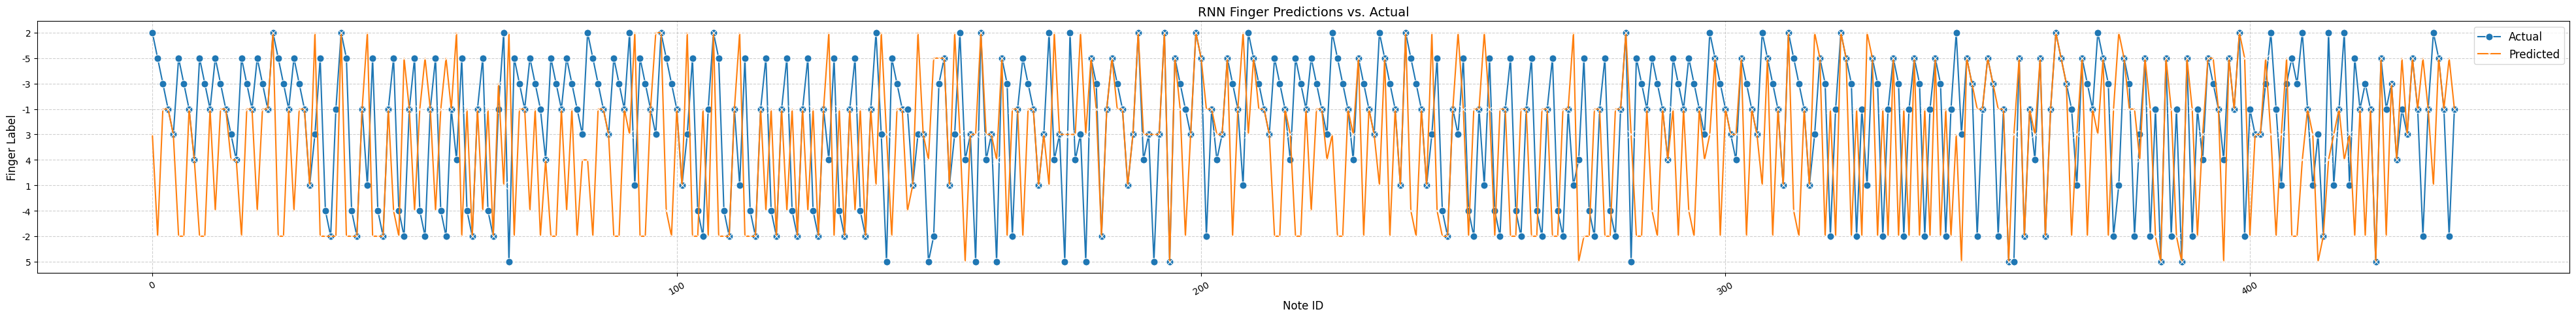

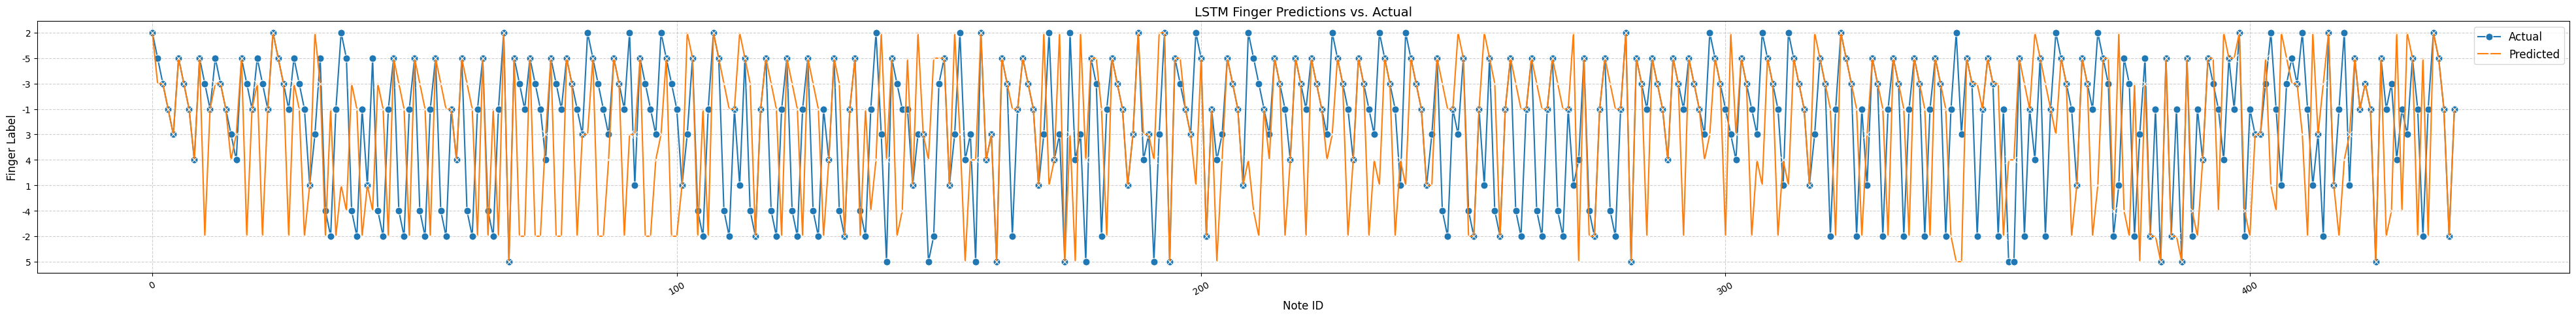

In [32]:
def plot_sequence_finger_predictions(note_ids, y_true, y_pred, model_name="RNN"):
    plt.figure(figsize=(50, 5))
    sns.lineplot(x=note_ids, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=note_ids, y=y_pred, marker='x', markersize=8, label='Predicted')
    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

# RNN
plot_sequence_finger_predictions(
    note_ids=np.arange(len(rnn_true_labels)),  # or df["noteID"] if available
    y_true=rnn_true_labels,
    y_pred=rnn_pred_labels,
    model_name="RNN"
)

# LSTM
plot_sequence_finger_predictions(
    note_ids=np.arange(len(lstm_true_labels)),
    y_true=lstm_true_labels,
    y_pred=lstm_pred_labels,
    model_name="LSTM"
)


# TRANSFORMERS
Let's define the architecture for our transformer: first you need positional encodings, and add that to the main transformer model (since we don't handle variable length sequences: model needs to know position from the vector).

In [126]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: embedding size
        max_len: maximum sequence length
        """
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns x + positional_encoding
        """
        seq_len = x.size(0)
        # Add the positional encoding to the input
        # shape => (seq_len, batch_size, d_model)
        x = x + self.pe[:seq_len, :].unsqueeze(1)
        return x


In [127]:
class MultiFeatureTransformerTagger(nn.Module):
    def __init__(
        self,
        num_pitches,      # vocabulary size for spelled_pitch
        num_fingers,      # number of finger classes
        pitch_emb_dim=64, # embedding dimension for pitch
        numeric_dim=5,    # number of numeric features (time, velocity, etc.)
        numeric_emb_dim=64,  # dimension to project numeric features
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    ):
        super().__init__()

        self.pitch_embedding = nn.Embedding(num_pitches, pitch_emb_dim)      # pitch to embedding
        self.numeric_projection = nn.Linear(numeric_dim, numeric_emb_dim)    # all other numeric features => numeric_emb_dim

        self.d_model = pitch_emb_dim + numeric_emb_dim        # total embedding size = pitch_emb_dim + numeric_emb_dim
        self.pos_encoder = PositionalEncoding(d_model=self.d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False  # (seq, batch, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final linear layer: map each token embedding -> finger label
        self.fc = nn.Linear(self.d_model, num_fingers)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, 6)
          - x[..., 0]: pitch (int)
          - x[..., 1:]: numeric feats (float)
        Returns: (batch_size, seq_len, num_fingers)
        """
        pitch_ids = x[..., 0].long()        # (batch_size, seq_len)
        numeric_feats = x[..., 1:].float()  # (batch_size, seq_len, 5)

        # pitch_emb => (batch_size, seq_len, pitch_emb_dim)
        pitch_emb = self.pitch_embedding(pitch_ids)

        # numeric_emb => (batch_size, seq_len, numeric_emb_dim)
        numeric_emb = self.numeric_projection(numeric_feats)

        # combine => (batch_size, seq_len, d_model)
        combined_emb = torch.cat((pitch_emb, numeric_emb), dim=2)

        # transform to shape (seq_len, batch_size, d_model) for the Transformer
        combined_emb = combined_emb.transpose(0, 1)  # => (seq_len, batch_size, d_model)

        encoded = self.pos_encoder(combined_emb)

        transformer_out = self.transformer_encoder(encoded)  # => (seq_len, batch_size, d_model)

        logits = self.fc(transformer_out)
        logits = logits.transpose(0, 1)  # => (batch_size, seq_len, num_fingers)
        return logits


## Training the Transformer

Remember, this is using the data variant that is defined earlier!

In [131]:
###############################################
# Train Transformer
###############################################
#   pitch_vocab = sorted set of pitches
#   finger_vocab = sorted set of finger labels
#   train_loader, val_loader, test_loader
#   Each batch => (X_seq, y_seq) with X_seq.shape=(batch_size, seq_len, 6)

from torch.optim import Adam

transformer_model = MultiFeatureTransformerTagger(
    num_pitches=len(pitch_to_int_mapping),
    num_fingers=len(finger_to_int_mapping),
    pitch_emb_dim=12,       # dimension for pitch embedding
    numeric_dim=5,           # e.g. onset_time, offset_time, onset_vel, offset_vel, channel
    numeric_emb_dim=32,     # project numeric feats to 128
    nhead=2,
    num_layers=2,
    dim_feedforward=128,     # example dimension in feedforward
    dropout=0.05
)

# state_dict = torch.load('transformer_model_weights.pth')
# transformer_model.load_state_dict(state_dict)

print("\n=== Training Multi-Feature TRANSFORMER ===")
train_sequence_model(transformer_model, train_loader, val_loader, num_epochs=10, lr=1e-3)
test_acc_transformer = evaluate_sequence_model(transformer_model, test_loader)
print(f"Transformer Test Accuracy = {test_acc_transformer*100:.2f}%")
torch.save(transformer_model.state_dict(), "transformer_model_weights.pth")    # we save the RNN model weights at the very end so we can load them in later!


=== Training Multi-Feature TRANSFORMER ===
Epoch 1/10 | Loss: 1.3038 | ValAcc: 0.6128
Epoch 2/10 | Loss: 0.9603 | ValAcc: 0.6402
Epoch 3/10 | Loss: 0.9008 | ValAcc: 0.6680
Epoch 4/10 | Loss: 0.8696 | ValAcc: 0.6727
Epoch 5/10 | Loss: 0.8453 | ValAcc: 0.6810
Epoch 6/10 | Loss: 0.8269 | ValAcc: 0.6928
Epoch 7/10 | Loss: 0.8144 | ValAcc: 0.6930


KeyboardInterrupt: 

### TRANSFORMER MODEL ANNOTATION DEMO

Load in a specific .txt file and print out the transfomer's accuracy on that file. (you can access the predicted labels in rnn_pred_labels!)

In [75]:
#   pitch_to_idx  : dict mapping spelled pitches -> int
#   finger_to_idx : dict mapping finger labels -> int
#   idx_to_finger : dict for decoding integer -> finger label

piece_file = "003-1_fingering.txt"
file_path = os.path.join(directory_path, piece_file)

transformer_preds, transformer_true, transformer_pred_labels, transformer_true_labels, transformer_acc = predict_piece_fingerings_multi(
    model=transformer_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_int_mapping,
    finger_to_idx=finger_to_int_mapping,
    idx_to_finger=int_to_finger_mapping
)


print(f"\n=== Multi-Feature TRANSFORMER Predictions for {piece_file} ===")
# print("Predicted fingerings (string labels):", rnn_pred_labels)
if transformer_true is not None and rnn_acc is not None:
    print("Accuracy on this piece:", f"{transformer_acc:.2f}%")
    # print("Actual fingerings (string labels):  ", rnn_true_labels)



=== Multi-Feature TRANSFORMER Predictions for 003-1_fingering.txt ===
Accuracy on this piece: 55.16%


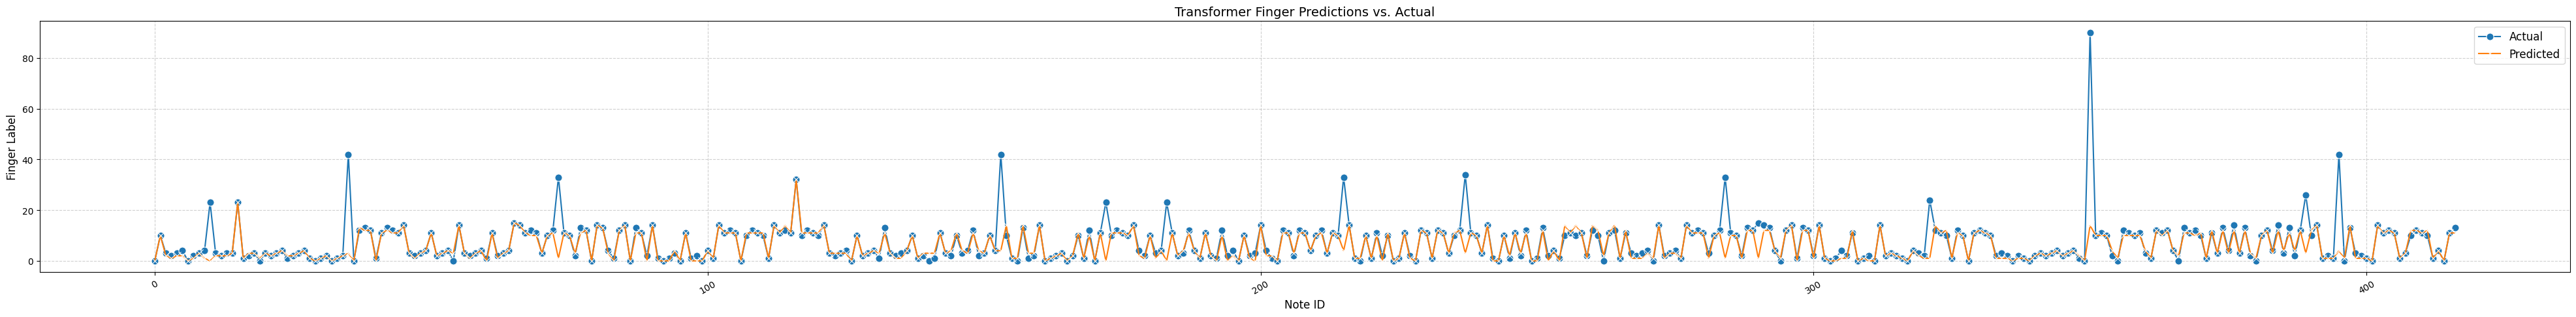

In [78]:
plot_sequence_finger_predictions(
    note_ids=np.arange(len(transformer_true)),
    y_true=transformer_true,
    y_pred=transformer_preds,
    model_name="Transformer"
)

# RANDOM USEFUL CODE EXAMPLES BELOW:
## How to load in a bunch of sequences from a specific file

In [ ]:
sequence_length = 10  # Define the sequence length

for filename in os.listdir(directory_path)[:5]:  # Iterate through files
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')  # Extract piece and fingering type
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    # Load the data
    df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
        "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity",
        "offset_velocity", "channel", "finger_number"
    ])

    # Separate features and labels
    num_data, num_features = df.shape
    x = df.iloc[:, 0:num_features - 1]
    y = df.iloc[:, num_features - 1]
    x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
    y = y.map(finger_to_int_mapping)  # Map finger labels to integers

    # Create sequences
    x_sequences, y_sequences = create_sequences(x, y, sequence_length=sequence_length)

    print(f"x_sequences shape: {x_sequences.shape}")
    print(f"y_sequences shape: {y_sequences.shape}")


x_sequences shape: (280, 10, 7)
y_sequences shape: (280, 10)
x_sequences shape: (582, 10, 7)
y_sequences shape: (582, 10)
x_sequences shape: (339, 10, 7)
y_sequences shape: (339, 10)
x_sequences shape: (184, 10, 7)
y_sequences shape: (184, 10)
x_sequences shape: (252, 10, 7)
y_sequences shape: (252, 10)


## Fitting a logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Initialize lists to accumulate all training data
X = []
Y = []

sequence_length = 5  # Define the sequence length

# Iterate through files
for filename in os.listdir(directory_path)[:100]:  # Process the first 10 files
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')  # Extract piece and fingering type
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    # Load the data
    df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
        "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity",
        "offset_velocity", "channel", "finger_number"
    ])

    # Separate features and labels
    num_data, num_features = df.shape
    x = df.iloc[:, 0:num_features - 1]
    y = df.iloc[:, num_features - 1]
    x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
    y = y.map(finger_to_int_mapping)  # Map finger labels to integers

    # Create sequences
    x_sequences, y_sequences = create_sequences(x, y, sequence_length=sequence_length)

    # Flatten x_sequences into [num_sequences * sequence_length, num_features]
    num_sequences, seq_len, num_features = x_sequences.shape
    x_flat = x_sequences.reshape(num_sequences * seq_len, num_features)  # Flatten sequences
    y_flat = y_sequences.flatten()  # Flatten y_sequences to match x_flat

    # Append to global X and Y
    X.append(x_flat)
    Y.append(y_flat)

# Concatenate all data into single arrays
X = np.vstack(X)  # Combine all x_flat into a single array
Y = np.concatenate(Y)  # Combine all y_flat into a single array

# Fit a logistic regression model to the combined data
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')  # Multinomial for multi-class classification
logistic_model.fit(X, Y)

# Predict on training data
Y_pred = logistic_model.predict(X)

# Compute and print metrics
accuracy = accuracy_score(Y, Y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(Y, Y_pred)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Accuracy: 0.2016
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.19      0.83      0.31     15753
           2       0.16      0.15      0.15     14228
           3       0.00      0.00      0.00     11627
           4       0.00      0.00      0.00      9013
           5       0.20      0.01      0.01      9111
           6       0.14      0.07      0.09      6734
           7       0.00      0.00      0.00      3388
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        20
          12       0.00      0.00      0.00      3847
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        35
          17       0.00      0.00      0.00        15
          19       0.00      0.00

/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/willy/Desktop/projects/smolgrad/smol/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# Load the piece and preprocess
file_path = os.path.join(directory_path, "001-1_fingering.txt")  # Replace with your piece file name

df = pd.read_table(file_path, sep="\t", skiprows=1, names=[
    "noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity",
    "offset_velocity", "channel", "finger_number"
])

# Preprocess features
x = df.iloc[:, :-1]
y = df.iloc[:, -1]
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)  # Map pitch to integers
y = y.map(finger_to_int_mapping)  # Map finger labels to integers

# Create sequences with padding if needed
def create_sequences_with_padding(x_df, sequence_length=10):
    """
    Create sequences with padding if the number of rows is not divisible by the sequence length.
    """
    num_notes, num_features = x_df.shape
    padded_length = ((num_notes + sequence_length - 1) // sequence_length) * sequence_length  # Round up
    padding_needed = padded_length - num_notes

    # Add zero padding to the end of the DataFrame
    x_padded = np.pad(x_df.values, ((0, padding_needed), (0, 0)), mode="constant", constant_values=0)

    # Reshape into sequences
    x_sequences = x_padded.reshape(-1, sequence_length, num_features)
    return x_sequences, num_notes  # Return original number of notes for truncation later

sequence_length = 10
x_sequences, original_num_notes = create_sequences_with_padding(x, sequence_length=sequence_length)

# Flatten sequences for prediction
num_sequences, seq_len, num_features = x_sequences.shape
x_flat = x_sequences.reshape(num_sequences * seq_len, num_features)

# Predict fingerings
predicted_fingerings = logistic_model.predict(x_flat)

# Reshape predictions to match sequence structure
predicted_fingerings = predicted_fingerings.reshape(num_sequences, seq_len)

# Truncate padded predictions to match original number of notes
predicted_fingerings = predicted_fingerings.flatten()[:original_num_notes]  # Remove padding

# Output predicted fingerings
print("Predicted Fingerings:")
print(predicted_fingerings)
print(y.to_numpy())

# Compute and print metrics
accuracy = accuracy_score(Y, Y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(Y, Y_pred)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Predicted Fingerings:
[ 1  1  1  1  1  1  1 46 55  1 55 55  1 55  1  1 55  1 55 55  1 55  1  1
 55  1  1  1  1  1  1 55  1 55 55  1 55  1  1 55  1 55 55  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1  1  0 55  1 55 55  1
 55  1  1 55 55  1 55  1 55  1  1 55  1  1 55  1  1 55  1  1 55  1  1 55
  1  1 55  1  1 55  1  1 55  1  1  1  1 55  1 55  1  1  1 55  1  1 55 57
 55 55 57 55 55 55  1  1 55  1  1 55  1  1 55  1  1 57 55 55 55 55 55 55
 55 57  1  1 55  1  1 55  1  1 55  1  0 55 55 55 55 55 55 55 55 55  1  1
 55  1  1 55  1  1 55  1  0 55 57 55 55 55 55 55 57 55  1  1 55  1  1 55
  1  1 55  1  1 55 57  0 57 55  1 55 57  1 55 57  1 57 55  0 55 55  0 55
 55  0 55 55  0 55 55  1 55 55  1 57 55  0 55 55  0 55 55  0 57 57  0 55
 57 57 55 57  1  1 55  1  0 55 57  1 55  1  1  1 57  1 57  1 57  1 55  1
 55  1 57  0 55  1 57  1 57  0 57  1 57  0 57  0 57  1 55  1 57  1 55  1
 55  1  1 57  1  1 55  1  1  

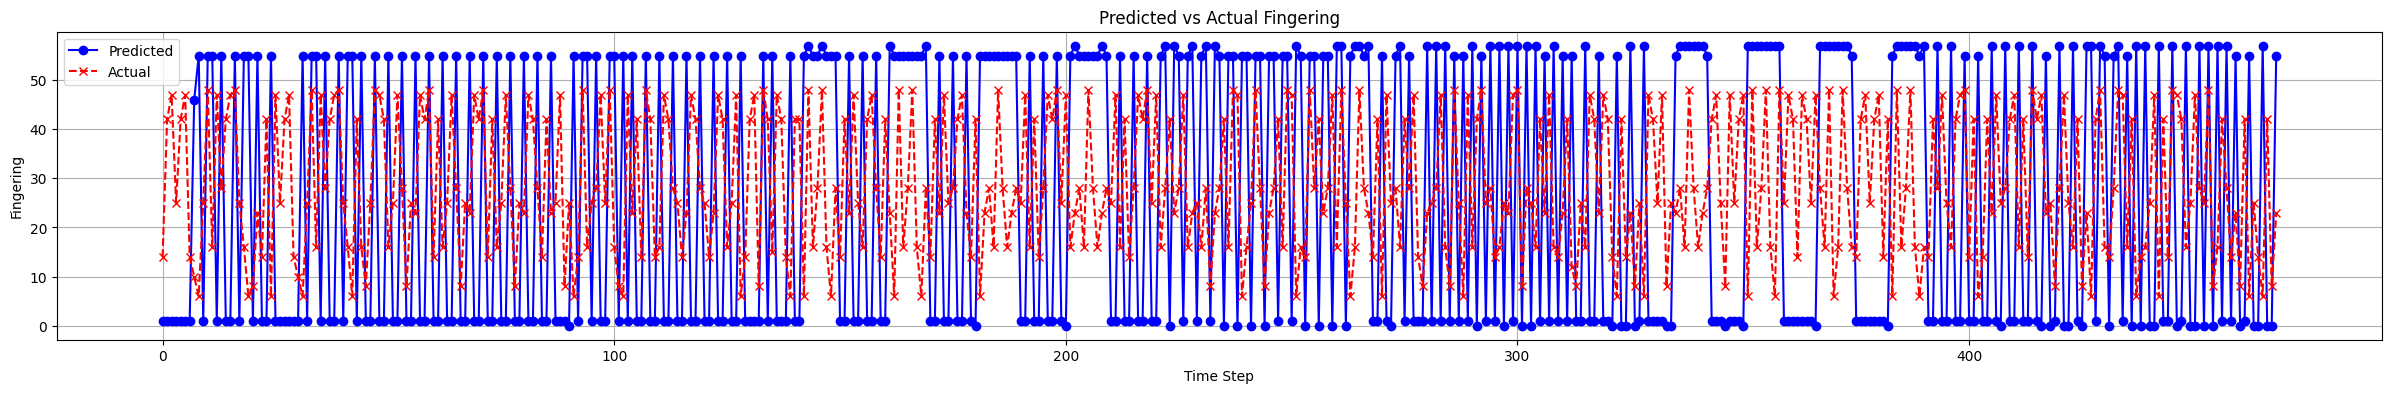

In [ ]:
# VISUALIZATION:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Step 6: Visualize the predictions vs actual labels
def visualize_comparison(preds, actuals):
    fig, ax = plt.subplots(figsize=(30, 4))
    x = range(len(preds))
    ax.plot(x, preds, label='Predicted', marker='o', linestyle='-', color='b')
    ax.plot(x, actuals, label='Actual', marker='x', linestyle='--', color='r')

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Fingering')
    ax.set_title('Predicted vs Actual Fingering')
    ax.legend()
    plt.grid(True)
    plt.show()

# Visualize comparison for a few sequences
visualize_comparison(predicted_fingerings, y.to_numpy())

#   OOOOOOOOOOOOOLLLLLLLLLLLLLLDDDDDDDDDDDD

In [ ]:
my_linear_model = LinearRegressionBaseline(num_features - 1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_linear_model.parameters(), lr=1e-2)    # Needs a VERY small learning rate, else NaN.


# normalize inputs before feeding to model
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()


print(x.shape)
print(y.shape)
print(my_linear_model(x).shape)


torch.Size([289, 7])
torch.Size([289, 1])
torch.Size([289, 1])


In [ ]:

epochs = 5000
for epoch in range(epochs):
    # Forward pass
    y_pred = my_linear_model(x)
    loss = criterion(y_pred, y)
#     print(x.shape)
#     print(y.shape)
#     print(y_pred)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [5000/5000], Loss: 0.7200


In [ ]:
# Check on testing set

x_test = x
y_test = y




# Ensure your model is in evaluation mode
my_linear_model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    # Forward pass: Predict on the test set
    y_test_pred = my_linear_model(x_test)

    # Calculate the loss on the test set
    test_loss = criterion(y_test_pred, y_test)

    # Optional: Convert predictions to numpy for further analysis if needed
    y_test_pred_np = y_test_pred.cpu().numpy() if y_test_pred.is_cuda else y_test_pred.numpy()
    y_test_np = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Print the results
print("Test Results:")
print(f"Test Loss: {test_loss.item():.4f}")
print("Sample Predictions:")
for i in range(min(5, len(y_test_pred))):  # Display up to 5 predictions
    print(f"Predicted: {y_test_pred_np[i]}, Actual: {y_test_np[i]}")

Test Results:
Test Loss: 0.7199
Sample Predictions:
Predicted: [0.2364006], Actual: [0.8806283]
Predicted: [0.0821104], Actual: [0.54707444]
Predicted: [0.09154606], Actual: [0.8806283]
Predicted: [0.3571701], Actual: [0.54707444]
Predicted: [-0.57786465], Actual: [-1.7878023]


In [ ]:
# Compare with Scikit Normal Equation Result

import numpy as np
from sklearn.linear_model import LinearRegression
import torch

# Assuming x and y are your training tensors
x_np = x.numpy() if isinstance(x, torch.Tensor) else x
y_np = y.numpy() if isinstance(y, torch.Tensor) else y
y_np = y_np.reshape(-1)

print(x_np.shape)
print(y_np.shape)


# Validate with Scikit-Learn
lr = LinearRegression(fit_intercept=True)
lr.fit(x_np, y_np)

# Print Scikit-Learn weights for comparison
print("Weights (Scikit-Learn):", np.hstack([lr.intercept_, lr.coef_]))


x_test_np = x_np
y_test_np = y_np

# Predict on the test set
y_test_pred = lr.predict(x_test_np)

# Compute Mean Squared Error (MSE) loss
test_loss = np.mean((y_test_pred - y_test_np) ** 2)

# Print the loss
print("Test Loss (Scikit-Learn):", test_loss)    # About the same loss: 0.53!

(289, 7)
(289,)
Weights (Scikit-Learn): [-9.9855537e+01  6.3732588e-01  1.2104809e-01 -3.0192924e+00
  2.3201710e-02  2.7132304e+00  2.4308480e-09 -9.6365234e+01]
Test Loss (Scikit-Learn): 0.16213986


# Idea 2: Add more layers

In [ ]:
# deep neural net with more layers

class DeepNeuralNet(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(DeepNeuralNet, self).__init__()
        self.mlp_layer = nn.Sequential(
            nn.Linear(input_dims, 4 * input_dims),
            nn.ReLU(),
            nn.Linear(4 * input_dims, output_dims),
        )


    def forward(self, x):
        return self.mlp_layer(x)

In [ ]:
dnn_model = DeepNeuralNet(num_features - 1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-2)    # Needs a VERY small learning rate, else NaN.


# normalize inputs before feeding to model
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()


print(x.shape)
print(y.shape)
print(dnn_model(x).shape)


# Adding more layers helps a lot!

epochs = 1000
for epoch in range(epochs):
    # Forward pass
    y_pred = dnn_model(x)
    loss = criterion(y_pred, y)
#     print(x.shape)
#     print(y.shape)
#     print(y_pred)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

torch.Size([289, 7])
torch.Size([289, 1])
torch.Size([289, 1])


# Testing code

Testing on some random other piece

In [ ]:
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path) and filename == os.listdir(directory_path)[1]:
        test_df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        print(filename)

x_test = test_df.iloc[:, 0:num_features - 1]
y_test = test_df.iloc[:, num_features - 1]

x_test['spelled_pitch'] = x_test['spelled_pitch'].map(pitch_to_int_mapping)


# print(x_test)

# NORMALIZE FIRST
# Normalize x_test
for col in x_test.columns:
    std = x_test[col].std()
    if std == 0:  # Check if all values are the same
        x_test[col] = 0  # Assign all entries in this column to 0
    else:
        x_test[col] = (x_test[col] - x_test[col].mean()) / std

# Normalize y_test
y_test_std = y_test.std()
if y_test_std == 0:  # Check if all values are the same
    y_test = 0  # Assign all entries in y_test to 0
else:
    y_test = (y_test - y_test.mean()) / y_test_std



x_test = torch.tensor(x_test.values.tolist(), dtype=torch.float32)
y_test = torch.tensor(y_test.values.astype(float).tolist())
y_test = y_test.unsqueeze(1)   # conver from size [289] to size [289, 1]


# print(y_test)


# print(x_test.isna().sum())
# print(y_test.shape)

026-5_fingering.txt


In [ ]:

# Check on testing set

# x_test = x
# y_test = y

# print(x_test)
# print(y_test)


# Ensure your model is in evaluation mode
dnn_model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    # Forward pass: Predict on the test set
    y_test_pred = dnn_model(x_test)

    # Calculate the loss on the test set
    test_loss = criterion(y_test_pred, y_test)

    # Optional: Convert predictions to numpy for further analysis if needed
    y_test_pred_np = y_test_pred.cpu().numpy() if y_test_pred.is_cuda else y_test_pred.numpy()
    y_test_np = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Print the results
print("Test Results:")
print(f"Test Loss: {test_loss.item():.4f}")
print("Sample Predictions:")
for i in range(min(5, len(y_test_pred))):  # Display up to 5 predictions
    print(f"Predicted: {y_test_pred_np[i]}, Actual: {y_test_np[i]}")

Test Results:
Test Loss: 997.6591
Sample Predictions:
Predicted: [-6.156381], Actual: [0.29965785]
Predicted: [-5.7688727], Actual: [0.6164696]
Predicted: [-6.2006125], Actual: [1.566905]
Predicted: [-62.680935], Actual: [-1.6012129]
Predicted: [-62.60875], Actual: [-0.33396572]


# Idea 3: Seq to Seq Modeling

Obviously the above doesn't work at all because the specific fingering DEPENDS on the previous fingerings!

In [ ]:
# Strategy 1: Recurrent Neural Network

# rnn = nn.RNN(10, 20, 2)
# i = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# output, hn = rnn(i, h0)


# 20, 512 seems to be OK: gets to a loss of like 0.5 or so - 21% accuracy
# seq 10, hidden 1024 also seems to get around 0.58. Slightly worse 13% - seems like more sequence length helps more than a larger hidden size
SEQ_LENGTH = 30
HIDDEN_SIZE = 512


In [ ]:
# Initialize an empty list to store DataFrames
dataframes = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        # Read the file into a DataFrame
        new_df = pd.read_table(
            file_path,
            sep="\t",
            skiprows=1,
            names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"]
        )

        dataframes.append(new_df)

# Concatenate all DataFrames in the list into a single DataFrame
train_df = pd.concat(dataframes, ignore_index=True)

### NEED TO NORMALIZE FULL DATAFRAME FIRST!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_columns = ['onset_time', 'offset_time', 'onset_velocity', 'offset_velocity']
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])




# some labels have "_" in them: default to using the int on the left!
train_df.iloc[:, num_features - 1] = train_df.iloc[:, num_features - 1].where(
    ~train_df.iloc[:, num_features - 1].str.contains('_', na=False),
    train_df.iloc[:, num_features - 1].str.split('_').str[0]
).astype(int)


# train_df = train_df.head(20000)  # for testing, we will only take the first 10000 rows. Can use more for training when you have GPUs



# Split into features (X) and target (y)
x_train = train_df.iloc[:, 0:num_features - 1]
y_train = train_df.iloc[:, num_features - 1]



# Map "spelled_pitch" to integers using the provided mapping
x_train['spelled_pitch'] = x_train['spelled_pitch'].map(pitch_to_int_mapping)
y_train = y_train.astype(int)

# Ensure target values (y_train) are positive for CrossEntropyLoss
y_train += 5

# # Print the maximum value of y_train to verify
# print("Maximum y_train value:", y_train.max())
# print(x_train)
# print(y_train)

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def create_sequences(x_df, y_series, sequence_length):
    x_sequences = []
    y_sequences = []
    for i in range(len(x_df) - sequence_length + 1):
        # Extract a sequence of notes (features)
        x_seq = x_df.iloc[i:i + sequence_length].values  # Shape: [T, num_features]
        # Extract the corresponding sequence of finger labels
        y_seq = y_series.iloc[i:i + sequence_length].values  # Shape: [T]
        x_sequences.append(x_seq)
        y_sequences.append(y_seq)

    return np.array(x_sequences, dtype=np.float32), np.array(y_sequences)

# Example usage
sequence_length = SEQ_LENGTH  # Define the sequence length
x_sequences, y_sequences = create_sequences(x_train, y_train, sequence_length)

# Convert to PyTorch tensors
x_sequences = torch.tensor(x_sequences, dtype=torch.float32)  # Shape: [num_sequences, T, num_features]
y_sequences = torch.tensor(y_sequences, dtype=torch.long)  # Shape: [num_sequences, T]

# print(x_sequences)
# print(y_sequences)

In [ ]:
class PianoDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create Dataset
dataset = PianoDataset(x_sequences, y_sequences)

from sklearn.model_selection import train_test_split

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    x_sequences, y_sequences, test_size=0.2, random_state=42
)

# Create Dataset objects
train_dataset = PianoDataset(x_train, y_train)
test_dataset = PianoDataset(x_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [ ]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape)  # [batch_size, sequence_length, num_features]
    print(y_batch.shape)  # [batch_size, sequence_length]
    # Pass x_batch to your RNN model


torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([512, 30, 7])
torch.Size([512, 30])
torch.Size([5

In [ ]:
# import torch
# import torch.nn as nn

# class SeqToSeqTransformer(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_heads=8, num_layers=4, dropout=0.1):
#         super(SeqToSeqTransformer, self).__init__()
#         # Embedding layer to project input features to hidden_size
#         self.embedding = nn.Linear(input_size, hidden_size)

#         # Transformer encoder
#         self.transformer = nn.Transformer(
#             d_model=hidden_size,
#             nhead=num_heads,
#             num_encoder_layers=num_layers,
#             num_decoder_layers=num_layers,
#             dim_feedforward=hidden_size * 4,
#             dropout=dropout,
#             batch_first=True
#         )

#         # Fully connected layer to map transformer output to output_size
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Embed input to the same dimension as hidden_size
#         x = self.embedding(x)

#         # For simplicity, using encoder-only transformer (typical for sequence classification or tagging)
#         # If needed, you can define and use a separate decoder
#         x = self.transformer(x, x)  # Pass through the transformer encoder

#         # Map to the output space
#         x = self.fc(x)
#         return x


# # Example usage

# # Assuming x_sequences is your input data
# input_size = x_sequences.shape[2]  # Number of features
# hidden_size = 512
# output_size = 11   # Number of unique finger labels

# # Instantiate and move the model to the GPU if available
# model = SeqToSeqTransformer(input_size, hidden_size, output_size).to(device)

# # Print model summary
# # print(model)

# SEQUENCE TO SEQUENCE MODULE
import torch.nn as nn

class SeqToSeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SeqToSeqRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Map hidden state to output size

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN output: [batch_size, sequence_length, hidden_size]
        out = self.fc(out)    # Output: [batch_size, sequence_length, output_size]
        return out

# Example
input_size = x_sequences.shape[2]  # Number of features
hidden_size = HIDDEN_SIZE
output_size = 11 # Number of unique finger labels
model = SeqToSeqRNN(input_size, hidden_size, output_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)



In [ ]:
# Training Loop
epochs = 100
model.train()  # Ensure the model is in training mode

for epoch in range(epochs):
    epoch_loss = 0

    for x_batch, y_batch in train_loader:
        # Move data to the device (GPU or CPU)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)  # Shape: [batch_size, sequence_length, output_size]
        loss = criterion(outputs.view(-1, output_size), y_batch.view(-1))  # Flatten for CrossEntropyLoss

        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")




Epoch [1/100], Loss: 0.4455
Epoch [2/100], Loss: 0.4435
Epoch [3/100], Loss: 0.4438
Epoch [4/100], Loss: 0.4438
Epoch [5/100], Loss: 0.4441
Epoch [6/100], Loss: 0.4420
Epoch [7/100], Loss: 0.4437
Epoch [8/100], Loss: 0.4417
Epoch [9/100], Loss: 0.4409
Epoch [10/100], Loss: 0.4398
Epoch [11/100], Loss: 0.4397
Epoch [12/100], Loss: 0.4395
Epoch [13/100], Loss: 0.4388
Epoch [14/100], Loss: 0.4395
Epoch [15/100], Loss: 0.4382
Epoch [16/100], Loss: 0.4396
Epoch [17/100], Loss: 0.4373
Epoch [18/100], Loss: 0.4378
Epoch [19/100], Loss: 0.4366
Epoch [20/100], Loss: 0.4367
Epoch [21/100], Loss: 0.4357
Epoch [22/100], Loss: 0.4364
Epoch [23/100], Loss: 0.4346
Epoch [24/100], Loss: 0.4343
Epoch [25/100], Loss: 0.4332
Epoch [26/100], Loss: 0.4345
Epoch [27/100], Loss: 0.4332
Epoch [28/100], Loss: 0.4329
Epoch [29/100], Loss: 0.4325
Epoch [30/100], Loss: 0.4321
Epoch [31/100], Loss: 0.4321
Epoch [32/100], Loss: 0.4322
Epoch [33/100], Loss: 0.4317
Epoch [34/100], Loss: 0.4312
Epoch [35/100], Loss: 0

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(x_batch)  # Shape: [batch_size, sequence_length, num_classes]

            # Calculate loss
            loss = criterion(outputs.view(-1, outputs.size(-1)), y_batch.view(-1))
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(outputs, dim=-1)  # Shape: [batch_size, sequence_length]
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

            # Accuracy calculation
            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.numel()

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)  # Shape: [total_sequences, sequence_length]
    all_targets = torch.cat(all_targets, dim=0)  # Shape: [total_sequences, sequence_length]

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy, all_preds, all_targets

# Assuming test_loader and model are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Evaluate the model
test_loss, test_accuracy, all_preds, all_targets = evaluate_model(model, test_loader, criterion, device)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.5170
Test Accuracy: 78.67%


In [ ]:
# Visualize predictions and true labels
import random

def visualize_predictions(preds, targets, num_examples=5):
    print("Example Predictions:")
    for i in range(num_examples):
        idx = random.randint(0, preds.size(0) - 1)  # Random sequence index
        print(f"Sequence {i + 1}:")
        print(f"Predicted: {preds[idx].tolist()}")
        print(f"Actual:    {targets[idx].tolist()}")
        print()

# Show some example predictions
visualize_predictions(all_preds, all_targets)


Example Predictions:
Sequence 1:
Predicted: [6, 4, 10, 6, 1, 7, 4, 6, 7, 4, 9, 6, 7, 0, 10, 6, 8, 4, 10, 6, 7, 9, 6, 8, 4, 9, 6, 0, 10, 7]
Actual:    [7, 4, 8, 6, 2, 7, 4, 6, 7, 4, 9, 6, 7, 0, 10, 6, 8, 4, 10, 6, 7, 10, 6, 8, 4, 9, 6, 2, 10, 7]

Sequence 2:
Predicted: [4, 3, 3, 8, 0, 2, 4, 8, 0, 2, 4, 8, 0, 2, 4, 0, 2, 4, 8, 8, 0, 2, 4, 0, 2, 4, 7, 0, 2, 4]
Actual:    [4, 2, 4, 7, 0, 2, 4, 8, 0, 2, 4, 8, 0, 2, 4, 0, 2, 4, 8, 8, 0, 2, 4, 0, 2, 4, 7, 0, 2, 4]

Sequence 3:
Predicted: [4, 10, 6, 7, 8, 0, 9, 6, 7, 4, 3, 9, 6, 7, 2, 4, 10, 6, 7, 2, 4, 10, 6, 7, 1, 4, 10, 6, 7, 1]
Actual:    [1, 10, 6, 7, 8, 0, 9, 6, 7, 4, 3, 10, 6, 8, 2, 4, 10, 6, 7, 3, 2, 10, 6, 7, 4, 3, 10, 6, 7, 2]

Sequence 4:
Predicted: [6, 0, 4, 8, 4, 4, 6, 4, 3, 6, 2, 4, 7, 3, 2, 6, 2, 4, 7, 3, 2, 6, 1, 4, 7, 1, 4, 8, 2, 2]
Actual:    [6, 3, 4, 7, 2, 4, 8, 3, 2, 6, 1, 4, 7, 3, 2, 6, 1, 4, 7, 3, 2, 6, 3, 2, 7, 1, 4, 8, 3, 2]

Sequence 5:
Predicted: [4, 9, 9, 2, 4, 10, 6, 2, 4, 9, 8, 6, 0, 4, 9, 6, 0, 4, 6, 7, 0, 4, 9, 

# Pretty good!

Now let's actually try printing out the fingerings for a random piece

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load the specific file
specific_file = os.listdir(directory_path)[10]  # Replace 10 with the desired index
file_path = os.path.join(directory_path, specific_file)

my_df = pd.DataFrame()

if os.path.isfile(file_path):
    print(f"ANNOTATING FILE: {specific_file}")
    my_df = pd.read_table(
        file_path,
        sep="\t",
        skiprows=1,
        names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"]
    )


column_name = "finger_number"  # Replace with the actual column name
if not pd.api.types.is_integer_dtype(my_df[column_name]):
    my_df.iloc[:, -1] = my_df.iloc[:, -1].where(
        ~my_df.iloc[:, num_features - 1].str.contains('_', na=False),
        my_df.iloc[:, num_features - 1].str.split('_').str[0]
    ).astype(int)




# Step 2: Preprocess the data
# Normalize and map spelled_pitch
my_df['spelled_pitch'] = my_df['spelled_pitch'].map(pitch_to_int_mapping)

features = my_df.iloc[:, :-1]
labels = my_df.iloc[:, -1].astype(int) + 5  # Adjust labels if necessary for CrossEntropyLoss



# Replace NaN or invalid mappings if needed
# features.fillna(0, inplace=True)


# Normalize features: CAN'T JUST DO MEAN / STD SINCE STD MIGHT BE 0!!!
for col in features.columns:
    std = features[col].std()
    if std == 0:  # Check if all values are the same
        features[col] = 0  # Assign all entries in this column to 0
    else:
        features[col] = (features[col] - features[col].mean()) / std









# Convert to PyTorch tensors
x_piece = torch.tensor(features.values, dtype=torch.float32).unsqueeze(0)  # Shape: [1, seq_len, num_features]
y_piece = torch.tensor(labels.values, dtype=int).unsqueeze(0)  # Shape: [1, seq_len]



# Step 3: Create a DataLoader
piece_dataset = TensorDataset(x_piece, y_piece)
piece_loader = DataLoader(piece_dataset, batch_size=1, shuffle=False)

# Step 4: Predict the fingering sequence
model.eval()
predicted_fingering = []

with torch.no_grad():
    for x_batch, _ in piece_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)  # Shape: [1, seq_len, num_classes]
        preds = torch.argmax(outputs, dim=-1)  # Shape: [1, seq_len]
        predicted_fingering = preds.squeeze(0).tolist()

# Step 5: Output the predictions
print(f"Predicted Fingering Sequence for {specific_file}:")
print(predicted_fingering)


# print out actual
print(f"Actual Fingering:")
print(labels.tolist())


# print out overall "loss"


ANNOTATING FILE: 144-1_fingering.txt
Predicted Fingering Sequence for 144-1_fingering.txt:
[6, 0, 1, 6, 7, 9, 6, 0, 4, 6, 7, 9, 6, 6, 6, 0, 6, 0, 4, 3, 6, 0, 4, 7, 7, 10, 0, 4, 7, 4, 2, 4, 2, 6, 7, 9, 0, 4, 6, 0, 6, 0, 6, 0, 4, 3, 4, 0, 3, 2, 6, 7, 9, 0, 4, 6, 0, 6, 0, 6, 7, 4, 6, 0, 7, 0, 4, 7, 3, 4, 3, 6, 2, 7, 0, 2, 0, 3, 3, 7, 1, 6, 0, 2, 3, 3, 8, 2, 7, 9, 2, 0, 6, 0, 6, 3, 2, 4, 6, 0, 2, 6, 6, 0, 3, 4, 2, 2, 2, 6, 2, 9, 0, 6, 3, 2, 3, 6, 0, 4, 6, 10, 0, 3, 4]
Actual Fingering:
[7, 4, 2, 10, 9, 8, 6, 0, 3, 9, 10, 9, 8, 7, 8, 0, 6, 2, 4, 3, 8, 2, 4, 7, 8, 7, 3, 0, 2, 4, 0, 4, 1, 8, 10, 9, 0, 2, 8, 3, 7, 4, 6, 3, 0, 2, 4, 2, 4, 0, 7, 8, 10, 0, 2, 9, 3, 8, 4, 7, 6, 0, 7, 2, 9, 4, 0, 8, 3, 4, 0, 7, 3, 8, 4, 1, 3, 4, 0, 6, 1, 10, 4, 4, 2, 3, 9, 2, 10, 6, 4, 0, 9, 4, 10, 0, 3, 4, 6, 0, 2, 9, 9, 4, 3, 4, 3, 4, 1, 9, 0, 7, 4, 9, 0, 3, 4, 6, 0, 2, 10, 10, 4, 3, 4]


In [ ]:
# print metrics for a specific piece
labels = labels.tolist()

# Calculate model loss and accuracy
def calc_metrics(preds, actuals, criterion):
    """
    Calculate the Cross-Entropy loss and accuracy for the predicted vs. actual labels.
    """

    num_wrong = 0

    if len(preds) != len(actuals):
        print("preds and actuals not of same size")
        return

    for i, value in enumerate(preds):
        if value != actuals[i]:
            num_wrong += 1
            print(f"error at pos {i}: note is {value} but should be {preds[i]}")

    print(f"num_wrong is {num_wrong}")
    print(f"len(preds) is {len(preds)}")

    accuracy = 1 - (num_wrong / len(preds))
    return accuracy

# print(predicted_fingering)
# print(labels.tolist())
# Calculate overall loss and accuracy
overall_accuracy = calc_metrics(predicted_fingering, labels, criterion)

# Print the overall loss and accuracy
# print(f"Overall Loss: {overall_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

error at pos 0: note is 6 but should be 6
error at pos 1: note is 0 but should be 0
error at pos 2: note is 1 but should be 1
error at pos 3: note is 6 but should be 6
error at pos 4: note is 7 but should be 7
error at pos 5: note is 9 but should be 9
error at pos 8: note is 4 but should be 4
error at pos 9: note is 6 but should be 6
error at pos 10: note is 7 but should be 7
error at pos 12: note is 6 but should be 6
error at pos 13: note is 6 but should be 6
error at pos 14: note is 6 but should be 6
error at pos 17: note is 0 but should be 0
error at pos 20: note is 6 but should be 6
error at pos 21: note is 0 but should be 0
error at pos 24: note is 7 but should be 7
error at pos 25: note is 10 but should be 10
error at pos 26: note is 0 but should be 0
error at pos 27: note is 4 but should be 4
error at pos 28: note is 7 but should be 7
error at pos 30: note is 2 but should be 2
error at pos 32: note is 2 but should be 2
error at pos 33: note is 6 but should be 6
error at pos 34: 

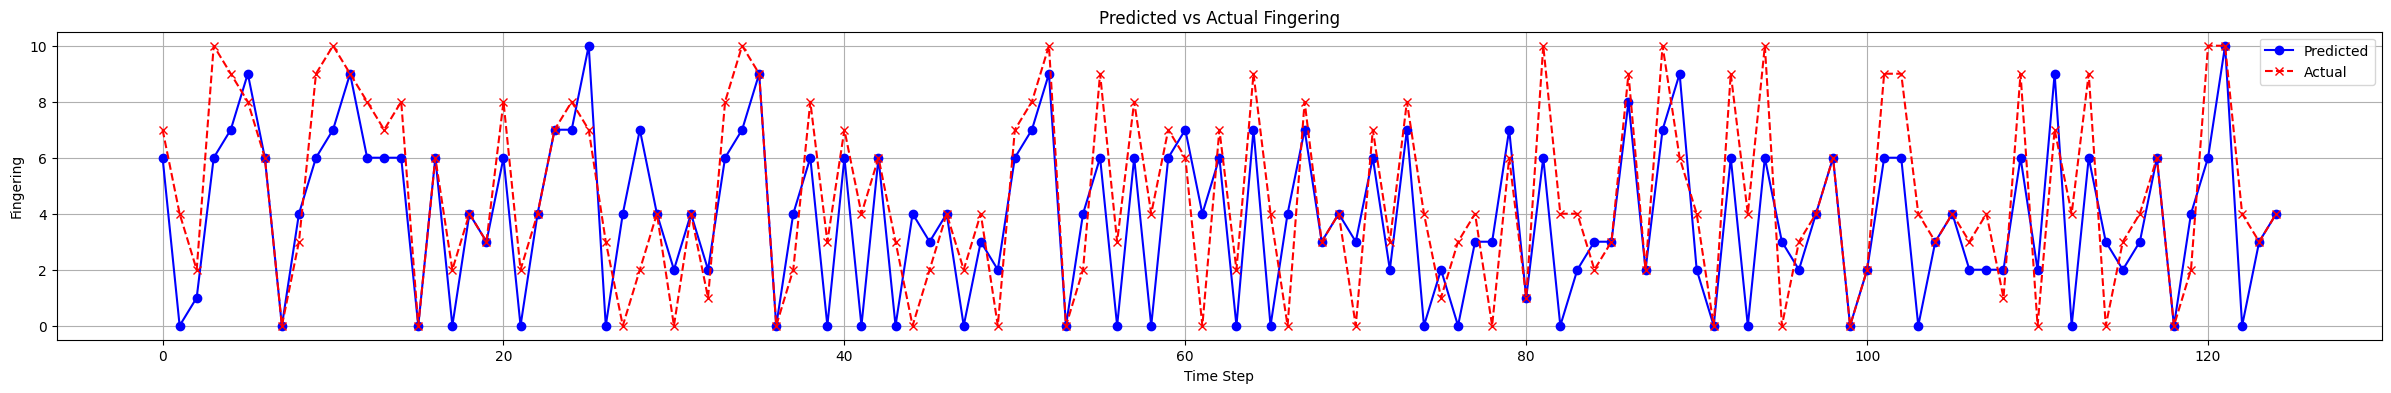

In [ ]:
# VISUALIZATION:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Step 6: Visualize the predictions vs actual labels
def visualize_comparison(preds, actuals):
    fig, ax = plt.subplots(figsize=(30, 4))
    x = range(len(preds))
    ax.plot(x, preds, label='Predicted', marker='o', linestyle='-', color='b')
    ax.plot(x, actuals, label='Actual', marker='x', linestyle='--', color='r')

    ax.set_xlabel('Time Step')
    ax.set_ylabel('Fingering')
    ax.set_title('Predicted vs Actual Fingering')
    ax.legend()
    plt.grid(True)
    plt.show()

# Visualize comparison for a few sequences
visualize_comparison(predicted_fingering, labels)